## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/analysisFunctions.py

## Download speech data

In [2]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [3]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835


In [4]:
trainDF.head()

,files,labels,category
0,speechData/train/happy/aac5b7c1_nohash_0.wav,18,happy
1,speechData/train/down/4cb874bb_nohash_0.wav,21,down
2,speechData/train/three/0ff728b5_nohash_0.wav,14,three
3,speechData/train/stop/abbfc3b4_nohash_1.wav,0,stop
4,speechData/train/right/c1d39ce8_nohash_3.wav,4,right


## Tensorflow 2.0

In [5]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 70kB/s 
     |████████████████████████████████| 501kB 39.7MB/s 
     |████████████████████████████████| 3.1MB 46.3MB/s 


In [6]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


## Input pipeline

In [7]:
!pip install -q python_speech_features

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 30000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False
)

test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False
) 


## Model

In [0]:
def lstmAttModel(input_shape=(99, 40)):
    '''
    Long-Short-Term-Memory model
    '''
    
    # Model Base
    model = tf.keras.models.Sequential()

    # Normalization Layer
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))

    # LSTM Layer
    model.add(
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(60, return_sequences=True, dropout=0.2)
        ))
  
      # Attention
  
#     query = tf.keras.layers.Lambda(lambda x: x[:,60])(model.layers[1].output)
#     query = tf.keras.layers.Dense(120)(query)
    
#     model.add(tf.keras.layers.Attention()([query,model.layers[1].output]))
    
    # Classification Layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(30, activation='softmax'))

    return model

In [0]:
# from models import lstmModel

model = lstmAttModel()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_24 (Batc (None, 99, 40)            160       
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 99, 120)           48480     
_________________________________________________________________
flatten_16 (Flatten)         (None, 11880)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               6083072   
_________________________________________________________________
dense_40 (Dense)             (None, 30)                15390     
Total params: 6,147,102
Trainable params: 6,147,022
Non-trainable params: 80
_________________________________________________________________


In [0]:
EPOCHS = 25

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR])



W0702 21:38:47.401106 139873620326144 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0702 21:38:47.404019 139873628718848 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0702 21:38:47.406708 139873620326144 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0702 21:38:47.414872 139873628718848 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0702 21:38:47.481031 139873628718848 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


Epoch 1/25
937/937 [==============================] - 288s 308ms/step - loss: 1.2665 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.7610 - val_sparse_categorical_accuracy: 0.7773
Epoch 2/25
937/937 [==============================] - 62s 66ms/step - loss: 0.6214 - sparse_categorical_accuracy: 0.8149 - val_loss: 0.5909 - val_sparse_categorical_accuracy: 0.8259
Epoch 3/25
937/937 [==============================] - 59s 63ms/step - loss: 0.4480 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.5644 - val_sparse_categorical_accuracy: 0.8407
Epoch 4/25
937/937 [==============================] - 60s 64ms/step - loss: 0.3496 - sparse_categorical_accuracy: 0.8922 - val_loss: 0.5686 - val_sparse_categorical_accuracy: 0.8519
Epoch 5/25
937/937 [==============================] - 61s 65ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.6275 - val_sparse_categorical_accuracy: 0.8445
Epoch 6/25
936/937 [============================>.] - ETA: 0s - loss: 0.2434 - sparse_ca

## Save model and trainign history  to drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir /content/gdrive/My\ Drive/Colab\ Notebooks/lstmModel

In [0]:
GDRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/lstmModel/"

## Save model 
model_json = model.to_json()
with open(GDRIVE_PATH + "model.json", "w") as file:
    file.write(model_json)
# serialize weights to HDF5
model.save_weights(GDRIVE_PATH + "model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


In [0]:
## test load
with open(GDRIVE_PATH + "train_results.pickle", 'rb') as handle:
    hist = pickle.load(handle)

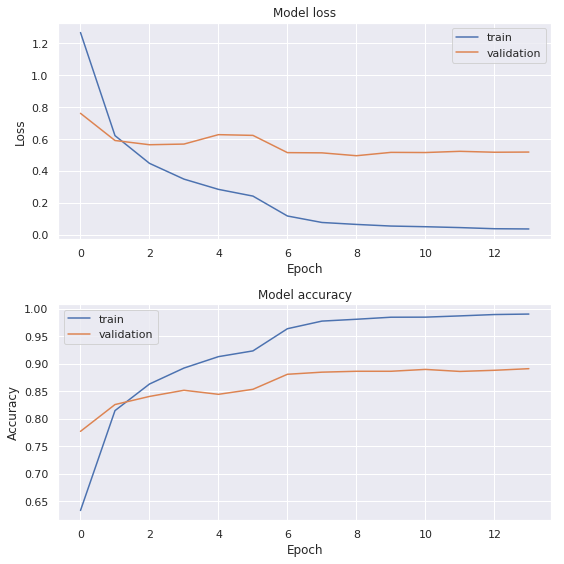

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

acc = hist['sparse_categorical_accuracy']
val_acc = hist['val_sparse_categorical_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

### Predict



In [0]:
out = model.predict(test_data, verbose=1)

214/214 [==============================] - 45s 211ms/step


In [0]:
import numpy as np
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist()

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
cm = confusion_matrix(y_pred, y_true)

Accuracy: 0.0410


/content/analysisFunctions.py:60: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


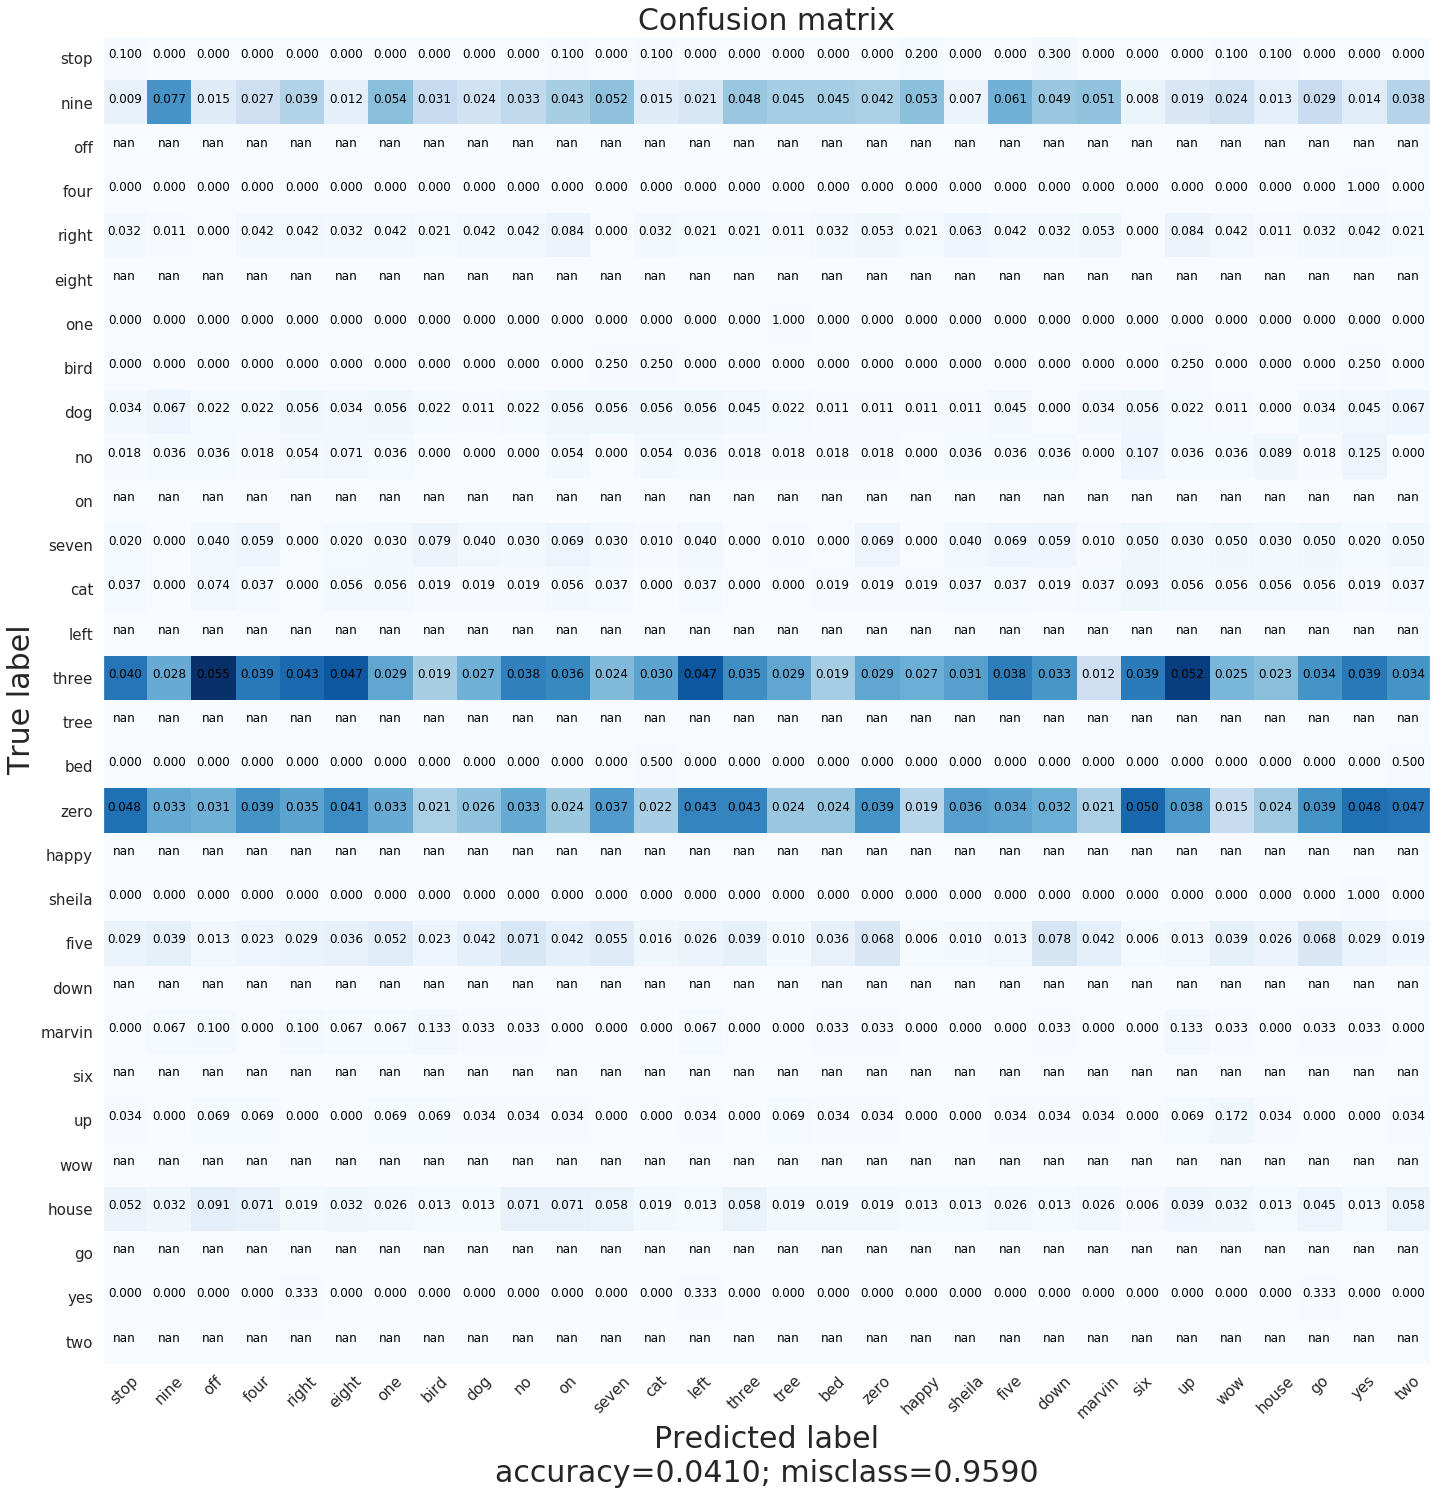

In [0]:
from analysisFunctions import plot_confusion_matrix
from constants import inv_categories
    
plot_confusion_matrix(cm, target_names=list(inv_categories.values())[:-1], normalize=True)